## Вступление

Всем привет! На сегодняшнем семинаре мы познакомимся с библиотекой **pytorch**. Он очень похож на numpy, с одним лишь отличием (на самом деле их больше, но сейчас мы поговорим про самое главное) -- pytorch может считать градиенты за вас. Таким образом вам не надо будет руками писать обратный проход в нейросетях. 

#### Семинар построен следующим образом:

1. Вспоминаем numpy и сравниваем операции в pytorch
2. Создаем тензоры в pytorch
3. Работаем с градиентами руками
4. Моя первая нейросеть 

### 1. Вспоминаем numpy и сравниваем операции в pytorch

Мы можем создавать матрицы, перемножать их, складывать, транспонировать и в целом совершать любые матричные операции

In [1]:
import numpy as np 
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from sklearn.datasets import load_boston
from tqdm.notebook import tqdm

%matplotlib inline

In [ ]:
a = np.random.rand(5, 3) # создали случайную матрицу 
a

In [ ]:
print("Проверили размеры : %s\n" % (a.shape,))

In [ ]:
print("Добавили 5 :\n%s\n" % (a + 5))

In [ ]:
print("X*X^T  :\n%s\n" % np.dot(a, a.T))

In [ ]:
print("Среднее по колонкам :\n%s\n" % (a.mean(axis=-1)))

In [ ]:
print("Изменили размеры :\n%s\n" % (a.reshape(3, 5).shape,))

#### Разминка.

При помощи numpy посчитайте сумму квадратов натуральных чисел от 1 до 10000.

In [ ]:
# YOUR CODE

Аналогичные операции в **pytorch** выглядят следующим образом, синтаксис отличается, но совсем немного:

In [ ]:
x = torch.rand(5, 3)
x

In [ ]:
print("Проверили размеры : %s\n" % (x.shape,))

In [ ]:
print("Добавили 5 :\n%s\n" % (x + 5))

In [ ]:
print("X*X^T  (1):\n%s\n" % (torch.matmul(x, x.transpose(1, 0))))
print("X*X^T  (2):\n%s\n" % (x.mm(x.t())))

In [ ]:
print("Среднее по колонкам :\n%s\n" % (x.mean(dim=-1)))

In [ ]:
print("Изменили размеры :\n%s\n" % (x.view([3, 5]).shape,))
print("Изменили размеры :\n%s\n" % (x.view_as(x.t()).shape,))

Небольшой пример того, как меняются операции:

* `x.reshape([1,2,8]) -> x.view(1,2,8)`

* `x.sum(axis=-1) -> x.sum(dim=-1)`

* `x.astype('int64') -> x.type(torch.LongTensor)`

Для помощи вам есть [таблица](https://github.com/torch/torch7/wiki/Torch-for-Numpy-users), которая поможет вам найти аналог операции в numpy


#### Разминка на pytorch

При помощи pytorch посчитайте сумму квадратов натуральных чисел от 1 до 10000.

In [ ]:
# YOUR CODE

### 2. Создаем тензоры в pytorch и снова изучаем базовые операции

In [ ]:
x = torch.empty(5, 3) # пустой тензор
print(x)

In [ ]:
x = torch.rand(5, 3) # тензор со случайными числами
print(x)

In [ ]:
x = torch.zeros(5, 3, dtype=torch.long) # тензор с нулями и указанием типов чисел
print(x)

In [ ]:
x = torch.tensor([5.5, 3]) # конструируем тензор из питоновского листа
print(x)

In [ ]:
x = x.new_ones(5, 3, dtype=torch.double) # используем уже созданный тензор для создания тензора из единичек
print(x, x.size()) 

In [ ]:
x = torch.randn_like(x, dtype=torch.float) # создаем матрицу с размерами как у x
print(x, x.size())

In [ ]:
y = torch.rand(5, 3)
print(x + y) # операция сложение

In [ ]:
z = torch.add(x, y) # очередная операция сложения
print(z)

In [ ]:
torch.add(x, y, out=z) # и наконец последний вид
print(z)

In [ ]:
print(x * y) # поэлементное умножение

In [ ]:
print(x @ y.t()) # матричное умножение

In [ ]:
print(x.mm(y.t())) # и опять матричное умножение

In [ ]:
print(x.unsqueeze(0).shape) # добавили измерение в начало, аналог броадкастинга 

In [ ]:
print(x.unsqueeze(0).squeeze(0).shape) # убрали измерение в начале, аналог броадкастинга 

Мы также можем делать обычные срезы и переводить матрицы назад в numpy:

In [4]:
a = np.ones((3, 5))
x = torch.ones((3, 5))
print(np.allclose(x.numpy(), a))
print(np.allclose(x.numpy()[:, 1], a[:, 1]))

True
True


### 3. Работаем с градиентами руками

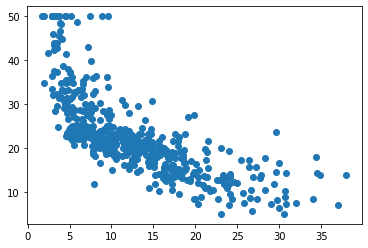

In [5]:
boston = load_boston()
plt.scatter(boston.data[:, -1], boston.target)

В pytorch есть возможность при создании тензора указывать нужно ли считать по нему градиент или нет, с помощью параметра `requires_grad`. Когда `requires_grad=True` мы сообщаем фреймворку, о том, что мы хотим следить за всеми тензорами, которые получаются из созданного. Иными словами, у любого тензора, у которого указан данный параметр, будет доступ к цепочке операций и преобразований совершенными с ними. Если эти функции дифференцируемые, то у тензора появляется параметр `.grad`, в котором хранится значение градиента.

![torch_grad.png](attachment:torch_grad.png)

Если к результирующему тензору применить метод `.backward()`, то фреймворк посчитает по цепочке градиенту для всех тензоров, у которых `requires_grad=True`.

In [6]:
w = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

x = torch.tensor(boston.data[:, -1] / boston.data[:, -1].max(), dtype=torch.float32)
y = torch.tensor(boston.target, dtype=torch.float32)

assert w.grad is None # только создали тензоры и в них нет градиентов
assert b.grad is None

In [7]:
y_pred = w * x + b                 # и опять совершаем операции с тензорами
loss = torch.mean((y_pred - y)**2) # совершаем операции с тензорами
loss.backward()                    # считаем градиенты

In [8]:
assert w.grad is not None # сделали операции и посчитали градиенты, значение должно было появится
assert b.grad is not None

print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)

dL/dw = 
 tensor([-12.0335])
dL/db = 
 tensor([-43.8109])


__Ремарка__. Для доступа к значениям в тензоре используйте атрибут `.data`:

In [10]:
w.data

tensor([0.2705])

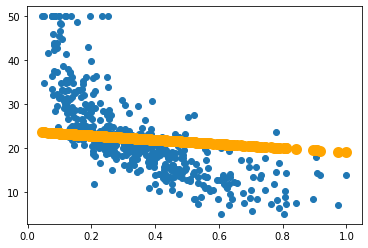

loss =  73.148476


In [11]:
from IPython.display import clear_output

for i in range(100):

    y_pred = w * x + b
    # попробуйте сделать полиномиальную регрессию в данном предсказании и посчитать градиенты после
    loss = torch.mean((y_pred - y)**2)
    loss.backward()

    # делаем шаг градиентного спуска с lr = .05
    w.data -= 0.05*w.grad
    b.data -= 0.05*b.grad

    # обнуляем градиенты, чтобы на следующем шаге опять посчитать и не аккумулировать их
    w.grad.data.zero_()
    b.grad.data.zero_()

    # рисуем картинки
    if (i+1) % 5 == 0:
        clear_output(True)
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.scatter(x.data.numpy(), y_pred.data.numpy(),
                    color='orange', linewidth=5)
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.5:
            print("Done!")
            break


### 4. Моя первая нейросеть

Для того, чтобы разобраться как обучать нейросите в pytorch, нужно освоить три вещи: 

1. Как формировать батчи и пихать их в сетку
2. Как сделать сетку
3. Как написать цикл обучения и отслеживать метрики

#### Как формировать батчи и пихать их в сетку

Чтобы в данном фреймворке иметь возможность итерироваться по данным и применять к ним преобразования, например, аугментации, о которых вы узнаете позже -- нужно создать свой класс унаследованный от `torch.utils.data.Dataset`.

Вот пример из документации:

```
class FaceLandmarksDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample
```

Как вы видите, у такого класса **должно быть** два метода: 

* `__len__` -- возвращает информацию о том, сколько объектов у нас в датасете
* `__getitem__` -- возвращает семпл и таргет к нему


Теперь давайте напишем такой сами, в качестве датасета сгенерируем рандомные данные.

In [ ]:
class RandomDataset(torch.utils.data.Dataset):
    """Our random dataset"""
    
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return {'sample': torch.tensor(x[idx, :], dtype=torch.float), 'target': y[idx]}

In [ ]:
x = np.random.rand(1000, 5)
y = np.random.rand(1000)

In [ ]:
our_dataset = RandomDataset(x, y)

In [ ]:
our_dataset.__getitem__(1)

Для того, чтобы из данных получать батчи в pytorch используется такая сущность как даталоадер, который принимает на вход класс унаследованный от `torch.utils.data.Dataset`. Сейчас посмотрим на пример:

In [ ]:
dataloader = torch.utils.data.DataLoader(our_dataset, batch_size=4)

Работают с ним следующим образом:

In [ ]:
for batch in dataloader:
    batch_x = batch['sample']
    batch_y = batch['target']
    break
print('Sample:', batch_x)
print('Target:', batch_y)

#### Как сделать сетку

Для того, чтобы в high-level pytorch создавать нейросети используется модуль `nn`. Нейросеть должна быть унаследована от класса `nn.Module`. Пример как это может выглядеть:

```
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
       x = F.relu(self.conv1(x))
       return F.relu(self.conv2(x))
```

Как мы видим на данном примере, у данного класса должно быть метод `forward`, который определяет прямой проход нейросети. Также из класса выше видно, что модуль `nn` содержит в себе реализацию большинства слоев, а модуль `nn.functional` -- функций активаций.

Есть еще один способ создать нейросеть и давайте его разберем на практике:

In [ ]:
model = nn.Sequential()                 # создаем пустую модель, в которую будем добавлять слои
model.add_module('l1', nn.Linear(5, 3)) # добавили слой с 5-ю нейронами на вход и 3-мя на выход
model.add_module('l2', nn.ReLU())       # добавили функцию активации
model.add_module('l3', nn.Linear(3, 1)) # добавили слой с 3-мя нейронами на вход и 5-ю на выход

In [ ]:
y_pred = model(batch_x) # получили предсказания модели

#### Как написать цикл обучения и отслеживать метрики
 
Давайте теперь соберем теперь загрузку данных, создание модели и обучим на уже созданном для нас датасете MNIST

In [ ]:
mnist_train = torchvision.datasets.MNIST(
    './mnist/', train=True, download=True, 
    transform=torchvision.transforms.ToTensor()
) # используем готовый класс от торча для загрузки данных для тренировки
mnist_val = torchvision.datasets.MNIST(
    './mnist/', train=False, download=True,
    transform=torchvision.transforms.ToTensor()
) # используем готовый класс от торча для загрузки данных для валидации

train_dataloader = torch.utils.data.DataLoader(
    mnist_train, batch_size=4, shuffle=True, num_workers=1
) # так как это уже унаследованный от Dataset класс, его можно сразу пихать в даталоадер

val_dataloader = torch.utils.data.DataLoader(
    mnist_val, batch_size=4, shuffle=True, num_workers=1
) # так как это уже унаследованный от Dataset класс, его можно сразу пихать в даталоадер

In [ ]:
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

In [ ]:
model = nn.Sequential(
    nn.Flatten(),        # превращаем картинку 28х28 в вектор размером 784
    nn.Linear(784, 128), # входной слой размером 784 нейронов с выходом в 128 нейронов
    nn.ReLU(),           # функция активации релу
    nn.Linear(128, 10),  # последний слой размером 128 нейронов с выходом 10 нейронов
    nn.Softmax(dim=-1)   # софтмакс для получения вероятностного распределения над метками класса
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05) # создаем оптимизатор и передаем туда параметры модели

Веса моделей хранятся в виде матриц и выглядят так:

In [ ]:
[x for x in model.named_parameters()] 

_Красиво_ трекать метрики в полуавтоматическом режиме мы будем в [wandb](https://wandb.ai). Для этого регистрируемся на сайте, устанавливаем и логинимся(это того стоит):

In [ ]:
!pip install wandb --upgrade --quiet
import wandb

wandb.login()

In [ ]:
wandb.init(project="pytorch-demo")  # инициализируем проект
wandb.watch(model)                  # сохраняем параметры сетки в wandb + просим следить за градиентами сетки
print()

Можно перейти по ссылке и следить за нашей моделью прямо во время обучения!

In [ ]:
for epoch in range(11): # всего у нас будет 10 эпох (10 раз подряд пройдемся по всем батчам из трейна)
    for x_train, y_train in tqdm(train_dataloader): # берем батч из трейн лоадера
        y_pred = model(x_train)                       # делаем предсказания
        loss = F.cross_entropy(y_pred, y_train)       # считаем лосс
        loss.backward()                               # считаем градиенты обратным проходом
        optimizer.step()                              # обновляем параметры сети
        optimizer.zero_grad()                         # обнуляем посчитанные градиенты параметров
    
    if epoch % 2 == 0:
        val_loss = []      # сюда будем складывать **средний по бачу** лосс
        val_accuracy = []
        with torch.no_grad(): # мы считаем качество, поэтому мы запрещаем фреймворку считать градиенты по параметрам
            for x_val, y_val in tqdm(val_dataloader):       # берем батч из вал лоадера
                y_pred = model(x_val)                       # делаем предсказания
                loss = F.cross_entropy(y_pred, y_val)       # считаем лосс
                val_loss.append(loss.numpy())               # добавляем в массив 
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
          
        # скидываем метрики на wandb и автоматом смотрим на графики
        wandb.log({"mean val loss": np.mean(val_loss),
                   "mean val accuracy": np.mean(val_accuracy)})
        # печатаем метрики
        print('Epoch: {epoch}, loss: {loss}, accuracy: {accuracy}'.format(
                epoch=epoch, loss=np.mean(val_loss), accuracy=np.mean(val_accuracy)
        ))

### Дополнительные материалы:

* [PyTroch на простейшем примере с пояснениями](https://github.com/Kaixhin/grokking-pytorch)
* [Хорошая книга про pytorch](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf)
* [Использование pytorch на GPU](https://pytorch.org/docs/master/notes/cuda.html)
* [Pytorch за 60 минут](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [Как устроено автоматическое дифференцирование в pytorch](http://videolectures.net/site/normal_dl/tag=1129745/deeplearning2017_johnson_automatic_differentiation_01.pdf)